In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gzip
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
import pandas as pd

df_dtrain = pd.read_csv('HiTS_500k/images_train.csv', engine='c', header=None)
df_ltrain = pd.read_csv('HiTS_500k/label_train.csv', engine='c', header=None)
#
#df_dtest = pd.read_csv('HiTS_500k/images_test.csv', engine='c', header=None)
#df_ltest = pd.read_csv('HiTS_500k/label_test.csv', engine='c', header=None)

df_dtrain.drop(df_dtrain.columns[-1], axis=1, inplace=True)
#df_dtest.drop(df_dtest.columns[-1], axis=1, inplace=True)

print(df_dtrain.shape)
print(df_ltrain.shape)
#print(df_dtest.shape)
#print(df_ltest.shape)


(250000, 1323)
(250000, 1)


In [312]:
# Number of workers for dataloader
workers = 10

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 42

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 50

# Size of feature maps in discriminator
ndf = 50

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
#lr = 0.0002
lrD = 0.0002
lrG = 0.00025

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2


In [162]:
dtrain = df_dtrain.to_numpy()
ltrain = df_ltrain.to_numpy()

#dtest = df_dtest.to_numpy()
#ltest = df_ltest.to_numpy()

#dfnp = dfnp.reshape(-1, 3, 21, 21)
#print(dfnp.shape)

# Reescalamiento a [0, 1]
dtrain_tensor = torch.from_numpy(dtrain.astype('float32')).reshape(-1, 3, 21, 21)
dtrain_tensor = torch.repeat_interleave(dtrain_tensor, repeats=2, dim=2)
dtrain_tensor = torch.repeat_interleave(dtrain_tensor, repeats=2, dim=3)

im_min = dtrain_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 3, 1, 1)
im_max = dtrain_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 3, 1, 1)
dtrain_tensor = (dtrain_tensor - im_min)/(im_max-im_min)

#dtest_tensor = torch.from_numpy(dtest.astype('float32')).reshape(-1, 3, 21, 21)
#dtest_tensor = torch.repeat_interleave(dtest_tensor, repeats=2, dim=2)
#dtest_tensor = torch.repeat_interleave(dtest_tensor, repeats=2, dim=3)

#im_min = dtest_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 3, 1, 1)
#im_max = dtest_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 3, 1, 1)
#dtest_tensor = (dtest_tensor - im_min)/(im_max-im_min)

print(dtrain_tensor.shape)
#print(dtest_tensor.shape)


torch.Size([250000, 3, 42, 42])


torch.Size([128, 1, 42, 42])
tensor([[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
         0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
         1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
         1, 0, 1, 1, 0, 1, 1, 0]])


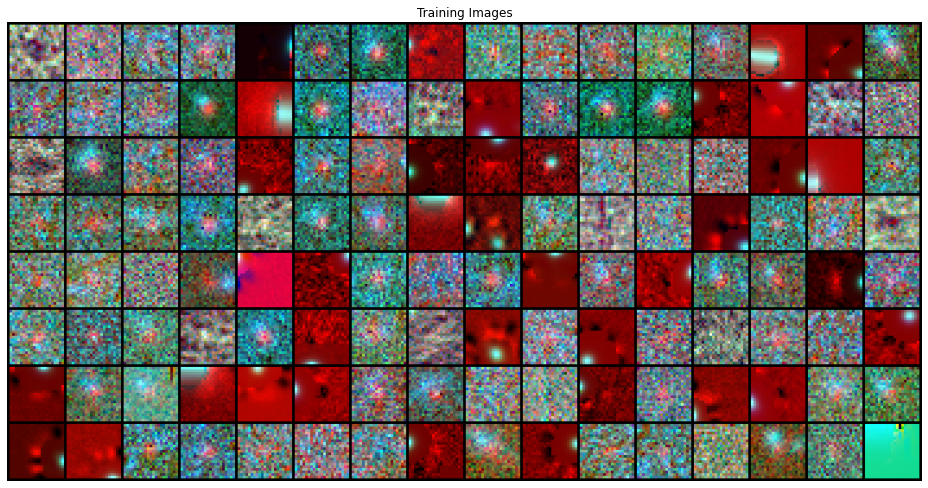

In [313]:
from torch.utils.data import TensorDataset, DataLoader, Subset

# Creación de DataSet y DataLoader
train_dataset = TensorDataset(dtrain_tensor, torch.from_numpy(ltrain.astype(dtype=np.int64)))
#test_dataset = TensorDataset(dtest_tensor, torch.from_numpy(ltest))

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)

#test_dataloader = DataLoader(test_dataset, 
#                              batch_size=32, 
#                              shuffle=True)



# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(13, 13), tight_layout=True)
plt.axis("off")
plt.title("Training Images")
print(real_batch[0][:, 0, :, :].unsqueeze(1).shape)
print(real_batch[1].reshape(1,-1))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True, nrow=16).cpu(),(1,2,0)), cmap=plt.cm.Greys_r)

In [314]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01) ## change
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [315]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        # z = 100 x 1 x 1
        self.conv1_1 = nn.ConvTranspose2d( nz, ngf * 2, 5, 1, 0, bias=False)
        self.bn1_1 = nn.BatchNorm2d(ngf * 2)
        
        self.conv1_2 = nn.ConvTranspose2d( 2, ngf * 2, 5, 1, 0, bias=False)
        self.bn1_2 = nn.BatchNorm2d(ngf * 2)
        
        # state size. 336 x 5 x 5

        self.conv2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        # state size. 168 x 11 x 11

        self.conv3 = nn.ConvTranspose2d( ngf * 2, ngf, 5, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)

        # state size. (ngf*2) x 21 x 21

        self.conv4 = nn.ConvTranspose2d( ngf, nc, 6, 2, 2, bias=False)

        # state size. (ngf) x 42 x 42

        self.fin = nn.Tanh()
        self.act = nn.ReLU(True)
        
        # state size. (3) x 42 x 42
        

    def forward(self, input, label):
        
        x = self.act(self.bn1_1(self.conv1_1(input)))
        y = self.act(self.bn1_2(self.conv1_2(label)))
        #print(x.shape)
        #print(y.shape)
        
        x = torch.cat([x, y], 1)
        #print(x.shape)

        x = self.act(self.bn2(self.conv2(x)))
        #print(x.shape)

        x = self.act(self.bn3(self.conv3(x)))
        #print(x.shape)

        x = self.fin(self.conv4(x))
        #print(x.shape)
        return x

In [316]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (conv1_1): ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn1_1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): ConvTranspose2d(2, 100, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn1_2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConvTranspose2d(200, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): ConvTranspose2d(100, 50, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose2d(50, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (fin): Tanh()
    (act): ReLU(inplace=True)
  )
)


/home/fquezada/.local/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [317]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()       
        
            # input is (nc) x 42 x 42
        self.conv1_1 = nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False)
        self.conv1_2 = nn.Conv2d(2, ndf//2, 4, 2, 1, bias=False)
            # state size. (ndf) x 21 x 21
        
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf * 2)
            # state size. (ndf*2) x 10 x 10
            
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
            # state size. (ndf*4) x 5 x 5
            
            
        self.conv4 = nn.Conv2d(ndf * 4, 1, 6, 2, 1, bias=False)
        # state size. (ndf*8) x 2 x 2
            
        #self.conv5 = nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False)
        self.capa5 = nn.Linear(ndf*8*2*2, 1)
        self.fin = nn.Sigmoid()
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, label):
        #print(x.shape)
        x = self.act(self.conv1_1(x))
        y = self.act(self.conv1_2(label))
        
        x = torch.cat([x, y], 1)
        #print(x.shape)
        
        x = self.act(self.bn1(self.conv2(x)))
        #print(x.shape)
        
        x = self.act(self.bn2(self.conv3(x)))
        #print(x.shape)
        
        #x = self.act(self.bn3(self.conv4(x)))
        x = self.fin(self.conv4(x))
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        
        #x = self.fin(self.capa5(x))
        
        return x

In [318]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


DataParallel(
  (module): Discriminator(
    (conv1_1): Conv2d(3, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv1_2): Conv2d(2, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(50, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(200, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (capa5): Linear(in_features=1600, out_features=1, bias=True)
    (fin): Sigmoid()
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)


In [319]:
# Initialize BCELoss function
criterion = nn.BCELoss()
#cristerion = nn.NLLLoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.
fake_label = 1. #invertidos

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))


In [320]:
fixed_labels1 = torch.ones(batch_size//2,1,1,1)
fixed_labels2 = torch.zeros(batch_size//2,1,1,1)

fixed_labels4 = torch.cat([fixed_labels1, fixed_labels2], dim=1)
fixed_labels3 = torch.cat([fixed_labels2, fixed_labels1], dim=1)

fixed_labels = torch.cat([fixed_labels4, fixed_labels3], dim=0).to(device)

In [321]:
# Training Loop
from torch.autograd import Variable
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch

FILENAME = "bestmodel"

n_classes = 2
bestlossG = 999999
bestlossD = 999999
#fixed_noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (n_classes**2, nz,1,1))).cuda())
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        
        real_y = torch.zeros(b_size, n_classes)
        real_y = real_y.scatter_(1, data[1].view(b_size, 1), 1).view(b_size, n_classes, 1, 1).contiguous()
        real_y = Variable(real_y.expand(-1, -1, image_size, image_size).cuda())
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        gen_labels = (torch.rand(b_size, 1) * n_classes).type(torch.LongTensor)
        gen_y = torch.zeros(b_size, n_classes)
        gen_y = Variable(gen_y.scatter_(1, gen_labels.view(b_size, 1), 1).view(b_size, n_classes,1,1).cuda())
  


        # ---------------------
        #  Train Discriminator Choo Chooo
        # ---------------------
        optimizerD.zero_grad()
        
        # Loss for real images
        d_real_loss = criterion(netD(real_cpu, real_y).squeeze(), label_real)
        # Loss for fake images
        gen_imgs = netG(noise, gen_y)
        gen_y_for_D = gen_y.view(b_size, n_classes, 1, 1).contiguous().expand(-1, -1, image_size, image_size)

        
        d_fake_loss = criterion(netD(gen_imgs.detach(), gen_y_for_D).squeeze(), label_fake)
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)/2.
        d_loss.backward()

        optimizerD.step()

        # Clip weights of discriminator
        #for p in netD.parameters():
        #    p.data.clamp_(-0.8, 0.8)
        
        # -----------------
        #  Train Generator
        # -----------------  
        
        optimizerG.zero_grad()

        g_loss = criterion(netD(gen_imgs, gen_y_for_D).squeeze(), label_real)
        g_loss.backward()
        optimizerG.step()
        

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     d_loss.item(), g_loss.item()))
            
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            #y_ = torch.LongTensor(np.array([num for num in range(n_classes)])).view(n_classes,1).expand(-1,n_classes).contiguous()
            #y_fixed = torch.zeros(n_classes**2, n_classes)
            #y_fixed = Variable(y_fixed.scatter_(1,y_.view(n_classes**2,1),1).view(n_classes**2, n_classes,1,1).cuda())
            
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
                #real = netG(fixed_noise, y_fixed).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=False, nrow=16))

        iters += 1
        


Starting Training Loop...
[1/15][0/1954]	Loss_D: 0.7118	Loss_G: 1.2508
[1/15][50/1954]	Loss_D: 0.7014	Loss_G: 3.1136
[1/15][100/1954]	Loss_D: 0.3976	Loss_G: 2.6873
[1/15][150/1954]	Loss_D: 0.4654	Loss_G: 2.4256
[1/15][200/1954]	Loss_D: 0.5400	Loss_G: 1.0600
[1/15][250/1954]	Loss_D: 0.5880	Loss_G: 1.8188
[1/15][300/1954]	Loss_D: 0.4536	Loss_G: 2.0971
[1/15][350/1954]	Loss_D: 0.3271	Loss_G: 1.7458
[1/15][400/1954]	Loss_D: 0.5005	Loss_G: 0.9740
[1/15][450/1954]	Loss_D: 0.6470	Loss_G: 3.8156
[1/15][500/1954]	Loss_D: 0.5543	Loss_G: 1.2389
[1/15][550/1954]	Loss_D: 0.6564	Loss_G: 2.5532
[1/15][600/1954]	Loss_D: 0.6485	Loss_G: 1.7938
[1/15][650/1954]	Loss_D: 0.6636	Loss_G: 0.9595
[1/15][700/1954]	Loss_D: 0.4819	Loss_G: 1.1972
[1/15][750/1954]	Loss_D: 0.4274	Loss_G: 1.1115
[1/15][800/1954]	Loss_D: 0.5464	Loss_G: 0.7231
[1/15][850/1954]	Loss_D: 0.2717	Loss_G: 2.0523
[1/15][900/1954]	Loss_D: 0.6978	Loss_G: 1.1777
[1/15][950/1954]	Loss_D: 0.4622	Loss_G: 1.3230
[1/15][1000/1954]	Loss_D: 0.3642	Loss

[5/15][650/1954]	Loss_D: 0.2727	Loss_G: 1.9987
[5/15][700/1954]	Loss_D: 0.2807	Loss_G: 4.0550
[5/15][750/1954]	Loss_D: 0.4430	Loss_G: 2.6652
[5/15][800/1954]	Loss_D: 0.4410	Loss_G: 2.3333
[5/15][850/1954]	Loss_D: 0.3566	Loss_G: 3.3183
[5/15][900/1954]	Loss_D: 0.3631	Loss_G: 3.0298
[5/15][950/1954]	Loss_D: 0.4350	Loss_G: 3.8414
[5/15][1000/1954]	Loss_D: 0.3510	Loss_G: 2.5163
[5/15][1050/1954]	Loss_D: 0.2433	Loss_G: 2.2342
[5/15][1100/1954]	Loss_D: 0.3378	Loss_G: 3.9342
[5/15][1150/1954]	Loss_D: 0.2889	Loss_G: 3.0522
[5/15][1200/1954]	Loss_D: 0.3569	Loss_G: 2.7186
[5/15][1250/1954]	Loss_D: 0.3538	Loss_G: 3.3256
[5/15][1300/1954]	Loss_D: 0.3704	Loss_G: 2.7992
[5/15][1350/1954]	Loss_D: 0.4067	Loss_G: 3.7689
[5/15][1400/1954]	Loss_D: 0.6078	Loss_G: 1.7652
[5/15][1450/1954]	Loss_D: 0.4461	Loss_G: 1.7571
[5/15][1500/1954]	Loss_D: 0.4350	Loss_G: 2.3268
[5/15][1550/1954]	Loss_D: 1.1523	Loss_G: 0.9550
[5/15][1600/1954]	Loss_D: 0.2441	Loss_G: 3.1995
[5/15][1650/1954]	Loss_D: 0.4454	Loss_G: 2.6223

[9/15][1300/1954]	Loss_D: 0.3944	Loss_G: 3.1772
[9/15][1350/1954]	Loss_D: 0.3535	Loss_G: 2.7485
[9/15][1400/1954]	Loss_D: 0.3859	Loss_G: 1.9965
[9/15][1450/1954]	Loss_D: 0.3378	Loss_G: 1.8051
[9/15][1500/1954]	Loss_D: 0.6202	Loss_G: 3.8912
[9/15][1550/1954]	Loss_D: 0.4904	Loss_G: 1.9223
[9/15][1600/1954]	Loss_D: 0.6648	Loss_G: 1.4937
[9/15][1650/1954]	Loss_D: 0.6223	Loss_G: 1.8869
[9/15][1700/1954]	Loss_D: 0.3899	Loss_G: 2.4998
[9/15][1750/1954]	Loss_D: 0.3480	Loss_G: 1.9974
[9/15][1800/1954]	Loss_D: 0.1928	Loss_G: 2.5805
[9/15][1850/1954]	Loss_D: 0.5956	Loss_G: 1.0601
[9/15][1900/1954]	Loss_D: 0.5542	Loss_G: 1.7043
[9/15][1950/1954]	Loss_D: 0.3942	Loss_G: 1.5779
[10/15][0/1954]	Loss_D: 0.4338	Loss_G: 2.6677
[10/15][50/1954]	Loss_D: 0.5446	Loss_G: 2.4928
[10/15][100/1954]	Loss_D: 0.2796	Loss_G: 2.8503
[10/15][150/1954]	Loss_D: 0.3855	Loss_G: 2.3696
[10/15][200/1954]	Loss_D: 0.3247	Loss_G: 2.3680
[10/15][250/1954]	Loss_D: 0.4819	Loss_G: 1.4430
[10/15][300/1954]	Loss_D: 0.6502	Loss_G: 2.

[13/15][1800/1954]	Loss_D: 0.9671	Loss_G: 1.1697
[13/15][1850/1954]	Loss_D: 0.4632	Loss_G: 1.7736
[13/15][1900/1954]	Loss_D: 0.3197	Loss_G: 1.6123
[13/15][1950/1954]	Loss_D: 0.6425	Loss_G: 2.8401
[14/15][0/1954]	Loss_D: 0.8110	Loss_G: 2.3911
[14/15][50/1954]	Loss_D: 0.4776	Loss_G: 1.4169
[14/15][100/1954]	Loss_D: 0.3953	Loss_G: 1.6107
[14/15][150/1954]	Loss_D: 0.4755	Loss_G: 1.4283
[14/15][200/1954]	Loss_D: 0.4083	Loss_G: 2.3327
[14/15][250/1954]	Loss_D: 0.4414	Loss_G: 2.4903
[14/15][300/1954]	Loss_D: 0.7253	Loss_G: 2.6293
[14/15][350/1954]	Loss_D: 0.3660	Loss_G: 3.0443
[14/15][400/1954]	Loss_D: 0.4709	Loss_G: 1.9115
[14/15][450/1954]	Loss_D: 0.4648	Loss_G: 1.6049
[14/15][500/1954]	Loss_D: 0.3040	Loss_G: 2.5769
[14/15][550/1954]	Loss_D: 0.5438	Loss_G: 1.3105
[14/15][600/1954]	Loss_D: 0.7424	Loss_G: 2.1259
[14/15][650/1954]	Loss_D: 0.3135	Loss_G: 2.4795
[14/15][700/1954]	Loss_D: 0.3356	Loss_G: 1.9903
[14/15][750/1954]	Loss_D: 0.9049	Loss_G: 2.1897
[14/15][800/1954]	Loss_D: 0.3112	Loss_G

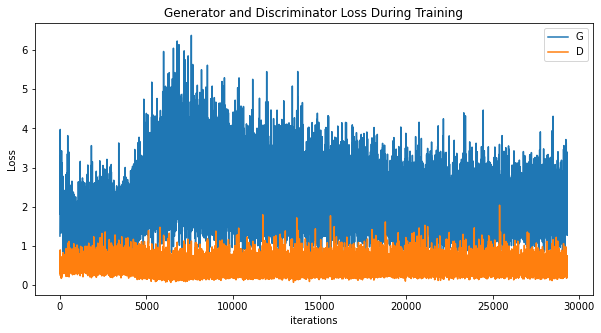

In [322]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")

plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [329]:
torch.save(netD.state_dict(), "discriminator.chk")
torch.save(netG.state_dict(), "generator.chk")

np.savetxt("gloss.csv", np.asarray(G_losses), delimiter=",")
np.savetxt("dloss.csv", np.asarray(D_losses), delimiter=",")

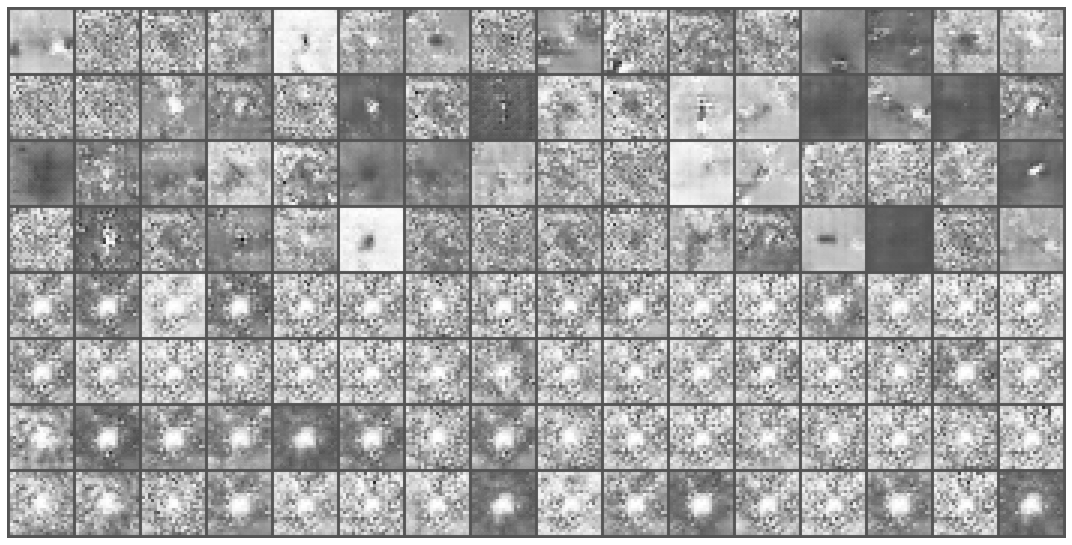

In [326]:
#%%capture
%matplotlib inline
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(15,10), tight_layout=True)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0))[:,:,0], animated=True, cmap=plt.cm.Greys_r)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=1000, blit=True)
#plt.show()
ani.save('diff.mp4')
#HTML(ani.to_jshtml())

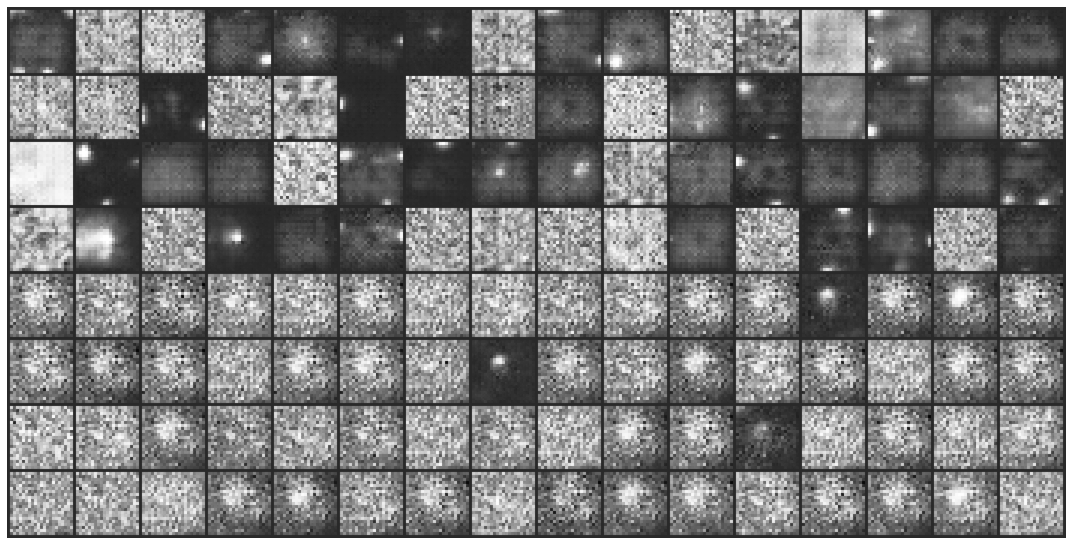

In [327]:
#%%capture
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(15,10), tight_layout=True)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0))[:,:,1], animated=True, cmap=plt.cm.Greys_r)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=1000, blit=True)
ani.save('diff1.mp4')

#HTML(ani.to_jshtml())

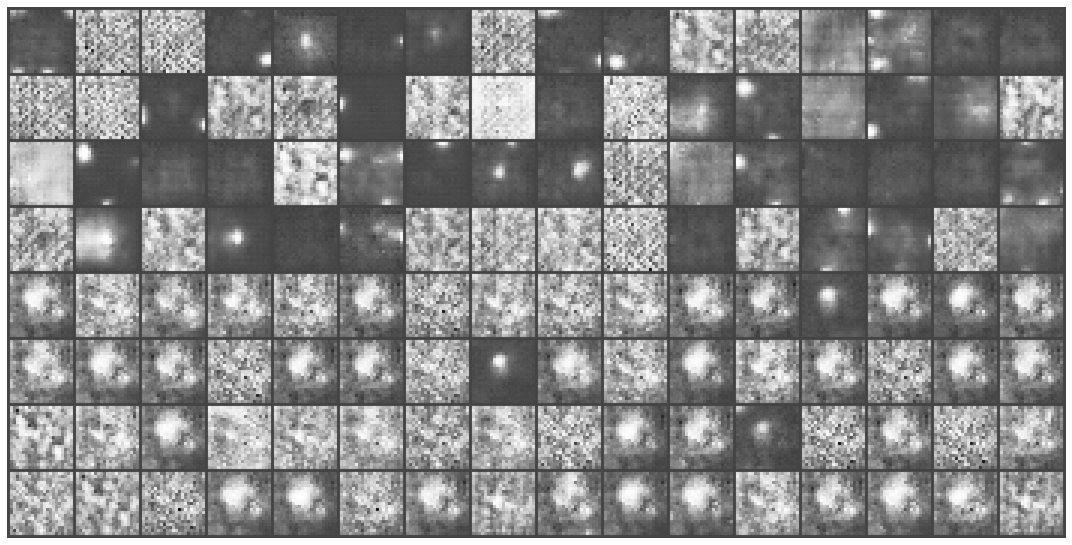

In [328]:
#%%capture
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(15,10), tight_layout=True)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0))[:,:,2], animated=True, cmap=plt.cm.Greys_r)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=1000, blit=True)
ani.save('diff2.mp4')

#HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

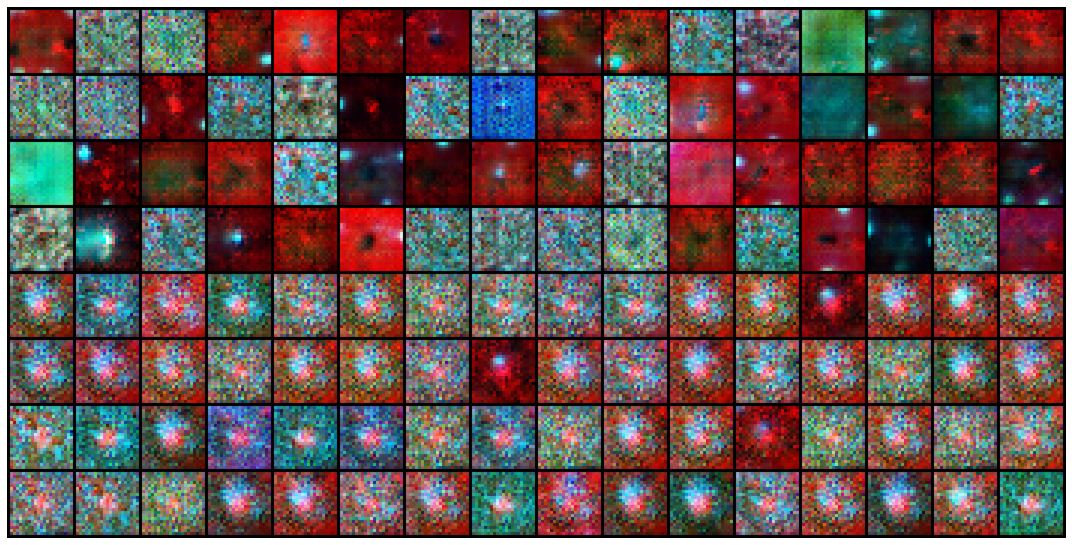

In [323]:
#%%capture
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(15,10), tight_layout=True)
plt.axis("off")
ims = [[plt.imshow((np.transpose(i,(1,2,0))[:,:,:]), animated=True, cmap=plt.cm.Greys_r)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=1000, blit=True)
ani.save('diffrgb.mp4')

#HTML(ani.to_jshtml())